In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import CatBoostEncoder
import numpy as np

In [2]:
# Set device dynamically (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the dataset
train_data = pd.read_csv('flight_data_train_ts.csv')
test_data = pd.read_csv('flight_data_test_ts.csv')

In [4]:
# Sort the dataset by datetime
train_data['scheduledoffblocktime'] = pd.to_datetime(train_data['scheduledoffblocktime'])
train_data = train_data.sort_values(by='scheduledoffblocktime')

# Extract datetime features from 'scheduledoffblocktime'
train_data['month'] = train_data['scheduledoffblocktime'].dt.month
train_data['day'] = train_data['scheduledoffblocktime'].dt.day
train_data['hour'] = train_data['scheduledoffblocktime'].dt.hour
train_data['day_of_week'] = train_data['scheduledoffblocktime'].dt.dayofweek

# Apply sine and cosine encoding for cyclical features
train_data['month_sin'] = np.sin(2 * np.pi * train_data['month'] / 12)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['month'] / 12)
train_data['day_sin'] = np.sin(2 * np.pi * train_data['day'] / 31)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['day'] / 31)
train_data['hour_sin'] = np.sin(2 * np.pi * train_data['hour'] / 24)
train_data['hour_cos'] = np.cos(2 * np.pi * train_data['hour'] / 24)
train_data['day_of_week_sin'] = np.sin(2 * np.pi * train_data['day_of_week'] / 7)
train_data['day_of_week_cos'] = np.cos(2 * np.pi * train_data['day_of_week'] / 7)

In [5]:
# Separate features and target variable
X = train_data.drop(columns=['delay_in_secs', 'scheduledoffblocktime', 'month', 'day', 'hour', 'day_of_week'])
y = train_data['delay_in_secs']

In [6]:
# Define columns for different encodings
catboost_cols = ['flightnumber', 'airlinecode_iata', 'destination_iata', 'aircraft_iata', 'aircraftparkingposition', 'publicgatenumber']
one_hot_cols = ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal']
scaler_cols = [col for col in X.columns if col not in catboost_cols + one_hot_cols + ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']]

In [7]:
# Apply CatBoost Encoding
catboost_encoder = CatBoostEncoder(cols=catboost_cols)
X_catboost_encoded = catboost_encoder.fit_transform(X[catboost_cols], y)

# Apply One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[one_hot_cols]), columns=one_hot_encoder.get_feature_names_out(one_hot_cols))

# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[scaler_cols]), columns=scaler_cols)

# Combine all encoded and scaled features
X_preprocessed = pd.concat([X_catboost_encoded, X_one_hot_encoded, X_scaled], axis=1)

In [8]:
# Split data into train and validation sets (last 10% for validation)
train_size = int(len(X_preprocessed) * 0.9)
X_train, X_val = X_preprocessed.iloc[:train_size], X_preprocessed.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [10]:
# Move data to the selected device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [14]:
# Define an LSTM-based model for time series regression
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, _ = self.lstm(x.unsqueeze(1), (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out


In [15]:
# Instantiate the LSTM model, define loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
num_layers = 3
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 3601592.9335, Validation Loss: 4197640.9247
Epoch 2/100, Train Loss: 3351451.2220, Validation Loss: 3984314.7798
Epoch 3/100, Train Loss: 3198296.9534, Validation Loss: 3854533.3853
Epoch 4/100, Train Loss: 3115546.5135, Validation Loss: 3787419.9286
Epoch 5/100, Train Loss: 3079759.8033, Validation Loss: 3758849.6792
Epoch 6/100, Train Loss: 3067757.1350, Validation Loss: 3748187.4381
Epoch 7/100, Train Loss: 3064556.4810, Validation Loss: 3744262.1627
Epoch 8/100, Train Loss: 3063893.1235, Validation Loss: 3742716.5245
Epoch 9/100, Train Loss: 3022329.2507, Validation Loss: 3698457.2438
Epoch 10/100, Train Loss: 2990040.7252, Validation Loss: 3686314.5590
Epoch 11/100, Train Loss: 2977895.4656, Validation Loss: 3674596.1499
Epoch 12/100, Train Loss: 2968423.4881, Validation Loss: 3662917.3943
Epoch 13/100, Train Loss: 2960405.1177, Validation Loss: 3641833.8526
Epoch 14/100, Train Loss: 2944190.3007, Validation Loss: 3636304.6657
Epoch 15/100, Train Loss: 293

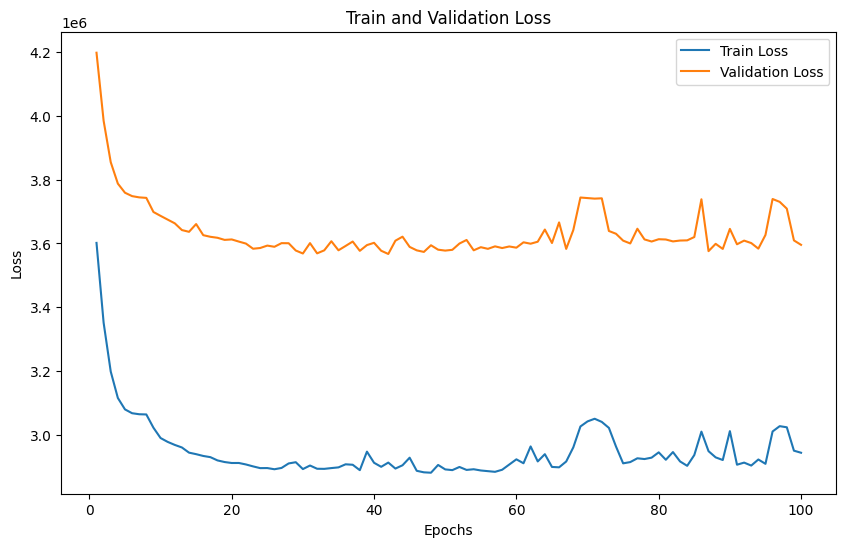

In [16]:
# Plotting train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

In [17]:
# Prepare the test data
test_data['scheduledoffblocktime'] = pd.to_datetime(test_data['scheduledoffblocktime'])
test_data['month'] = test_data['scheduledoffblocktime'].dt.month
test_data['day'] = test_data['scheduledoffblocktime'].dt.day
test_data['hour'] = test_data['scheduledoffblocktime'].dt.hour
test_data['day_of_week'] = test_data['scheduledoffblocktime'].dt.dayofweek

# Apply sine and cosine encoding for cyclical features
test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / 12)
test_data['day_sin'] = np.sin(2 * np.pi * test_data['day'] / 31)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['day'] / 31)
test_data['hour_sin'] = np.sin(2 * np.pi * test_data['hour'] / 24)
test_data['hour_cos'] = np.cos(2 * np.pi * test_data['hour'] / 24)
test_data['day_of_week_sin'] = np.sin(2 * np.pi * test_data['day_of_week'] / 7)
test_data['day_of_week_cos'] = np.cos(2 * np.pi * test_data['day_of_week'] / 7)

X_test = test_data.drop(columns=['delay_in_secs', 'scheduledoffblocktime', 'month', 'day', 'hour', 'day_of_week'])
y_test = test_data['delay_in_secs']

# Apply the same transformations to the test data
X_test_catboost_encoded = catboost_encoder.transform(X_test[catboost_cols])
X_test_one_hot_encoded = pd.DataFrame(one_hot_encoder.transform(X_test[one_hot_cols]), columns=one_hot_encoder.get_feature_names_out(one_hot_cols))
X_test_scaled = pd.DataFrame(scaler.transform(X_test[scaler_cols]), columns=scaler_cols)
X_test_preprocessed = pd.concat([X_test_catboost_encoded, X_test_one_hot_encoded, X_test_scaled], axis=1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_preprocessed.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_loss = criterion(y_test_pred, y_test_tensor).item()

print(f"Test Loss: {test_loss:.4f}")


Test Loss: 2984090.5000


In [ ]:




# Sort the dataset by datetime
train_data['scheduledoffblocktime'] = pd.to_datetime(train_data['scheduledoffblocktime'])
train_data = train_data.sort_values(by='scheduledoffblocktime')

# Extract datetime features from 'scheduledoffblocktime'
train_data['month'] = train_data['scheduledoffblocktime'].dt.month
train_data['day'] = train_data['scheduledoffblocktime'].dt.day
train_data['hour'] = train_data['scheduledoffblocktime'].dt.hour
train_data['day_of_week'] = train_data['scheduledoffblocktime'].dt.dayofweek

# Apply sine and cosine encoding for cyclical features
train_data['month_sin'] = np.sin(2 * np.pi * train_data['month'] / 12)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['month'] / 12)
train_data['day_sin'] = np.sin(2 * np.pi * train_data['day'] / 31)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['day'] / 31)
train_data['hour_sin'] = np.sin(2 * np.pi * train_data['hour'] / 24)
train_data['hour_cos'] = np.cos(2 * np.pi * train_data['hour'] / 24)
train_data['day_of_week_sin'] = np.sin(2 * np.pi * train_data['day_of_week'] / 7)
train_data['day_of_week_cos'] = np.cos(2 * np.pi * train_data['day_of_week'] / 7)

# Separate features and target variable
X = train_data.drop(columns=['delay_in_secs', 'scheduledoffblocktime', 'month', 'day', 'hour', 'day_of_week'])
y = train_data['delay_in_secs']

# Define columns for different encodings
catboost_cols = ['flightnumber', 'airlinecode_iata', 'destination_iata', 'aircraft_iata', 'aircraftparkingposition', 'publicgatenumber']
one_hot_cols = ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal']
scaler_cols = [col for col in X.columns if col not in catboost_cols + one_hot_cols]

# Apply CatBoost Encoding
catboost_encoder = CatBoostEncoder(cols=catboost_cols)
X_catboost_encoded = catboost_encoder.fit_transform(X[catboost_cols], y)

# Apply One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[one_hot_cols]), columns=one_hot_encoder.get_feature_names_out(one_hot_cols))

# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[scaler_cols]), columns=scaler_cols)

# Combine all encoded and scaled features
X_preprocessed = pd.concat([X_catboost_encoded, X_one_hot_encoded, X_scaled], axis=1)

# Split data into train and validation sets (last 10% for validation)
train_size = int(len(X_preprocessed) * 0.9)
X_train, X_val = X_preprocessed.iloc[:train_size], X_preprocessed.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Set device dynamically (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to the selected device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define an LSTM-based model for time series regression
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        
        out, _ = self.lstm(x.unsqueeze(1), (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the LSTM model, define loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plotting train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Prepare the test data
test_data['scheduledoffblocktime'] = pd.to_datetime(test_data['scheduledoffblocktime'])
test_data['month'] = test_data['scheduledoffblocktime'].dt.month
test_data['day'] = test_data['scheduledoffblocktime'].dt.day
test_data['hour'] = test_data['scheduledoffblocktime'].dt.hour
test_data['day_of_week'] = test_data['scheduledoffblocktime'].dt.dayofweek

# Apply sine and cosine encoding for cyclical features
test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / 12)
test_data['day_sin'] = np.sin(2 * np.pi * test_data['day'] / 31)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['day'] / 31)
test_data['hour_sin'] = np.sin(2 * np.pi * test_data['hour'] / 24)
test_data['hour_cos'] = np.cos(2 * np.pi * test_data['hour'] / 24)
test_data['day_of_week_sin'] = np.sin(2 * np.pi * test_data['day_of_week'] / 7)
test_data['day_of_week_cos'] = np.cos(2 * np.pi * test_data['day_of_week'] / 7)

X_test = test_data.drop(columns=['delay_in_secs', 'scheduledoffblocktime', 'month', 'day', 'hour', 'day_of_week'])
y_test = test_data['delay_in_secs']

# Apply the same transformations to the test data
X_test_catboost_encoded = catboost_encoder.transform(X_test[catboost_cols])
X_test_one_hot_encoded = pd.DataFrame(one_hot_encoder.transform(X_test[one_hot_cols]), columns=one_hot_encoder.get_feature_names_out(one_hot_cols))
X_test_scaled = pd.DataFrame(scaler.transform(X_test[scaler_cols]), columns=scaler_cols)
X_test_preprocessed = pd.concat([X_test_catboost_encoded, X_test_one_hot_encoded, X_test_scaled], axis=1)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test_preprocessed.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_loss = criterion(y_test_pred, y_test_tensor).item()

print(f"Test Loss: {test_loss:.4f}")
